Este PINN resuelve la integral indefinida:
$$
I(x) = \int e^{-t^{2}}\, dt
$$
transformandola en la EDO:
$$
\frac{dI_\theta}{dx} = e^{-x^{2}} 
$$
con constante de integracion $C=0$, y funcion de perdida:
$$
\mathcal{L} = \left( \frac{dI_\theta}{dx} - e^{-x^{2}} \right)^{2} + \left( I_\theta(0) \right)^{2}
$$


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import time

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [32]:
N = 100
x_max = 10
lr = 0.5e-3      
layers = 4       
neuronas = 128   
epocs = 10_000   

In [33]:
# Modelo

class FunAct(nn.Module):
    def forward(self,x):
        return torch.tanh(x)


class MLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas +=[nn.Linear(width, out_dim)]
        self.net=nn.Sequential(*capas)    

    def forward(self, x):
        return self.net(x)

In [34]:
model = MLP().to(device)

In [35]:
def muestreo(N):
    return torch.rand(N, 1, device=device)*x_max

def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]

In [36]:
tiempo_0 = time.time()

loss_valores = []

optimizador = torch.optim.Adam(model.parameters(), lr)

for step in range(epocs):

    optimizador.zero_grad()

    x = muestreo(N).clone().detach().requires_grad_()
    u = model(x)
    u_x = D(u,x)
    res = u_x - torch.exp(-x**2)

    x0 = torch.tensor([0.0],device=device)
    u0 = model(x0)
    C = 0.0 # constante de integracion
    
    loss = (res**2).mean() + (u0-C)**2

    loss_valores.append(loss.item())
    loss.backward()
    optimizador.step()

    if step % 1000 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e} | {step*100/epocs}% {int((abs(tiempo_0-time.time())*abs(epocs-step)/(step+0.00000001))/60)} minutos restantes")


step    0 | loss 7.642e-02 | 0.0% 193317731 minutos restantes
step 1000 | loss 2.544e-07 | 10.0% 1 minutos restantes
step 2000 | loss 9.907e-08 | 20.0% 1 minutos restantes
step 3000 | loss 6.379e-08 | 30.0% 0 minutos restantes
step 4000 | loss 2.310e-07 | 40.0% 0 minutos restantes
step 5000 | loss 4.704e-08 | 50.0% 0 minutos restantes
step 6000 | loss 1.965e-08 | 60.0% 0 minutos restantes
step 7000 | loss 3.063e-08 | 70.0% 0 minutos restantes
step 8000 | loss 6.218e-08 | 80.0% 0 minutos restantes
step 9000 | loss 1.617e-07 | 90.0% 0 minutos restantes


Text(0, 0.5, 'Loss')

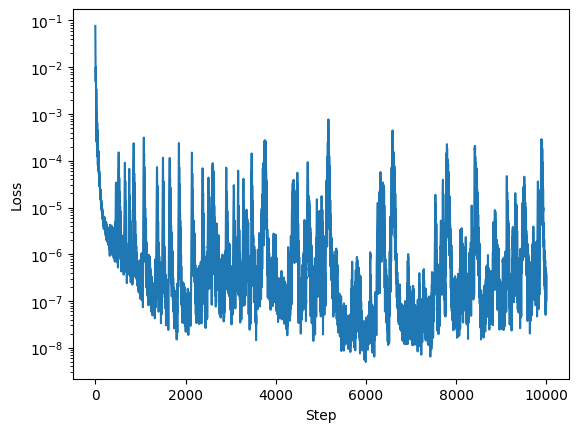

In [37]:
import matplotlib.pyplot as plt
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Loss")


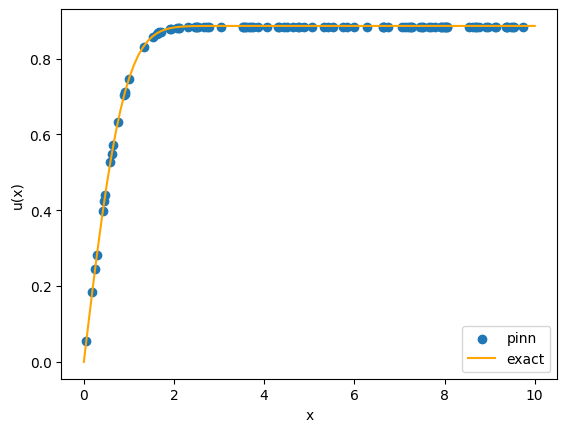

In [ ]:
from scipy.special import erf

with torch.no_grad():
    x_g = muestreo(N).clone().detach().requires_grad_()

    x_vals = x_g.detach().cpu().numpy()
    u_vals = model(x_g).detach().cpu().numpy()

def u_exacta(x):
    return np.sqrt(np.pi)*erf(x)/2

x_poblado = np.linspace(0,x_max,len(x_vals))

plt.scatter(x_vals,u_vals,label='pinn')
plt.plot(x_poblado,u_esacta(x_poblado),'orange',label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()